This notebook uses the GPyTorch package to apply Gaussian Process regression to the multi-step energy consumption forecasting problem.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpytorch
import torch

from gpytorch.kernels import ScaleKernel, LinearKernel, PeriodicKernel, AdditiveKernel, ProductKernel
from gpytorch.constraints import Interval
from gpytorch.priors import NormalPrior
from sklearn.preprocessing import MinMaxScaler

In [2]:
random_seed = 1923

In [3]:
# Set Torch settings
torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('medium')

In [4]:
# Plot settings
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [5]:
output_dir = "./OutputData/"

In [6]:
df = pd.read_csv(output_dir + "full_data.csv")
df["time"] = pd.to_datetime(df["time"], format = "%d:%m:%Y:%H:%M")

In [7]:
# Drop generation columns
gen_cols = df.columns.values[2:].tolist()
df = df.drop(gen_cols, axis = 1)

In [8]:
df

,time,consumption_MWh
0,2018-01-01 00:00:00,27412.81
1,2018-01-01 01:00:00,26324.39
2,2018-01-01 02:00:00,24635.32
3,2018-01-01 03:00:00,23872.12
4,2018-01-01 04:00:00,23194.89
...,...,...
52579,2023-12-31 19:00:00,35090.93
52580,2023-12-31 20:00:00,33310.94
52581,2023-12-31 21:00:00,32083.96
52582,2023-12-31 22:00:00,30469.49


## Data prep

We do not need to cyclical encode seasonal features, as we will apply a periodic kernel to them.

In [9]:
# Add time columns

# Trend
df["trend"] = df.index.values

# Hour of day
df["hour"] = df.time.dt.hour + 1

# Day of week
df["dayofweek"] = df.time.dt.dayofweek + 1

# Month
df["month"] = df.time.dt.month

In [10]:
df

,time,consumption_MWh,trend,hour,dayofweek,month
0,2018-01-01 00:00:00,27412.81,0,1,1,1
1,2018-01-01 01:00:00,26324.39,1,2,1,1
2,2018-01-01 02:00:00,24635.32,2,3,1,1
3,2018-01-01 03:00:00,23872.12,3,4,1,1
4,2018-01-01 04:00:00,23194.89,4,5,1,1
...,...,...,...,...,...,...
52579,2023-12-31 19:00:00,35090.93,52579,20,7,12
52580,2023-12-31 20:00:00,33310.94,52580,21,7,12
52581,2023-12-31 21:00:00,32083.96,52581,22,7,12
52582,2023-12-31 22:00:00,30469.49,52582,23,7,12


In [11]:
# Split features & target, create tensors
X = torch.tensor(
        df.drop(["time", "consumption_MWh",
                 #"hour", "dayofweek", "month"
                ], axis = 1).values, dtype = torch.float32)
y = torch.tensor(
        df["consumption_MWh"].values, dtype = torch.float32)

In [12]:
# Evaluation parameters that match the sequence2sequence testing scheme
horizon = 32 # Forecast horizon
first_t = df[df["time"] == '2022-10-18 16:00:00'].index[0] # First prediction point
stride = 24 # Number of timesteps between each prediction point

In [66]:
# Initial train - test split, subset
X_train, X_test = X[40000:first_t, :], X[first_t:-10000, :]
y_train, y_test = y[40000:first_t], y[first_t:-10000:]

In [67]:
# Feature & target scaling
scaler = MinMaxScaler()
X_train = torch.tensor(scaler.fit_transform(X_train))
X_test = torch.tensor(scaler.transform(X_test))

scaler_target = MinMaxScaler()
y_train = torch.tensor(scaler_target.fit_transform(y_train.unsqueeze(-1))).squeeze()
y_test = torch.tensor(scaler_target.transform(y_test.unsqueeze(-1))).squeeze()

Clean up the data splitting & scaling code.

## Model & wrapper definition

Switch to sparse / variational inference with minibatch optimization.
Covariance kernel is likely fine.

In [68]:
# ExactGP model class
class ExactGPModel(gpytorch.models.ExactGP):

    def __init__(self, X_train, y_train, likelihood):
        super().__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.mean_module = gpytorch.means.ZeroMean()
        self.covariance_module = AdditiveKernel(
            LinearKernel(active_dims = 0),
            #ScaleKernel(LinearKernel(active_dims = 0)),
            ScaleKernel(PeriodicKernel(
                active_dims = (1),
                period_length_prior = NormalPrior(24, 1)
                #period_length_constraint = Interval(23, 25) 
            )),
            ScaleKernel(PeriodicKernel(
                active_dims = (2),
                period_length_prior = NormalPrior(7, 1),
                #period_length_constraint = Interval(6, 8) 
            )),
            ScaleKernel(PeriodicKernel(
                active_dims = (3),
                period_length_prior = NormalPrior(12, 1)
                #period_length_constraint = Interval(11, 13) 
            )),
        )

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covariance_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [69]:
# ExactGP wrapper class
class ExactGP:
    
    def __init__(self, model, likelihood, cuda = True):
        self.model = model
        self.likelihood = likelihood
        self.cuda = cuda

    # Training method
    def train(self, X_train, y_train, max_epochs, learning_rate = 0.1, early_stop = 10, early_stop_tol = 1e-4):

        # Put tensors on GPU if cuda is enabled
        if self.cuda:
            X_train = X_train.cuda()
            y_train = y_train.cuda()
            self.model = self.model.cuda()
            self.likelihood = self.likelihood.cuda()

        # Find optimal kernel hyperparameters
        self.model.train()
        self.likelihood.train()

        # Create Adam optimizer with model parameters
        optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)

        # Create marginal log likelihood loss
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        # Training loop
        for epoch in range(max_epochs):

            # Reset gradients
            optimizer.zero_grad()

            # Get outputs from model
            output = self.model(X_train)

            # Calculate loss and perform backpropagation
            loss = -mll(output, y_train)
            loss.backward()

            # Print epoch info & update model parameters
            loss_scalar = loss.item()
            noise = self.model.likelihood.noise.item()
            print(f"Epoch: {epoch+1}/{max_epochs}, Loss: {loss_scalar}, Noise: {noise}")
            optimizer.step()

            # Initialize best loss & rounds with no improvement if first epoch
            if epoch == 0:
                self._best_epoch = epoch
                self._best_loss = loss_scalar
                self._epochs_no_improvement = 0

            # Record an epoch with no improvement
            if self._best_loss < loss_scalar - early_stop_tol:
                self._epochs_no_improvement += 1

            # Early stop if necessary
            if self._epochs_no_improvement >= early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

            # Record an improvement in the loss
            if self._best_loss > loss_scalar:
                self.best_epoch = epoch
                self._best_loss = loss_scalar
                self._epochs_no_improvement = 0
                
    # Method to update model training data (kernel hyperparameters unchanged, no additional training)
    def update_train(self, X_update, y_update):
        
        # Put tensors on GPU if cuda is enabled
        if self.cuda:
            X_update = X_update.cuda()
            y_update = y_update.cuda()

        # Update model training data
        self.model = self.model.get_fantasy_model(X_update, y_update)

    # Predict method
    def predict(self, X_test, cpu = True, fast_preds = False):

        # Test data to GPU, if cuda enabled
        if self.cuda:
            X_test = X_test.cuda()

        # Activate eval mode
        self.model.eval()
        self.likelihood.eval()

        # Make predictions without gradient calculation
        with torch.no_grad(), gpytorch.settings.fast_pred_var(state = fast_preds):

            # Returns the model posterior distribution over functions p(f*|x*, X, y)
            # Noise is not yet added to the functions
            f_posterior = self.model(X_test)

            # Returns the predictive posterior distribution p(y*|x*, X, y)
            # Noise is added to the functions
            y_posterior = self.likelihood(f_posterior)

            # Get posterior predictive mean & prediction intervals
            # By default, 2 standard deviations around the mean
            y_mean = y_posterior.mean
            y_lower, y_upper = y_posterior.confidence_region()

        # Return data to CPU if desired
        if cpu:
            y_mean = y_mean.cpu()
            y_lower = y_lower.cpu()
            y_upper = y_upper.cpu()

        return y_mean, y_lower, y_upper

In [70]:
# Create model & likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)
trainer = ExactGP(model, likelihood)

In [71]:
trainer.train(X_train, y_train, max_epochs = 100, early_stop_tol = 1e-4)

Epoch: 1/100, Loss: 0.9445879915642358, Noise: 0.6932471990585327
Epoch: 2/100, Loss: 0.9062479114870796, Noise: 0.644496738910675
Epoch: 3/100, Loss: 0.8666427273158757, Noise: 0.5982131958007812
Epoch: 4/100, Loss: 0.8249832275357154, Noise: 0.5543709993362427
Epoch: 5/100, Loss: 0.7838463849901982, Noise: 0.5129239559173584
Epoch: 6/100, Loss: 0.7424737054144235, Noise: 0.4738294780254364
Epoch: 7/100, Loss: 0.7007097631765906, Noise: 0.43703821301460266
Epoch: 8/100, Loss: 0.6590601354232414, Noise: 0.40249547362327576
Epoch: 9/100, Loss: 0.6163981242978228, Noise: 0.3701397180557251
Epoch: 10/100, Loss: 0.573811960828974, Noise: 0.33990100026130676
Epoch: 11/100, Loss: 0.530883292572477, Noise: 0.3117045760154724
Epoch: 12/100, Loss: 0.4869515001819623, Noise: 0.2854703962802887
Epoch: 13/100, Loss: 0.44225272024159396, Noise: 0.2611136734485626
Epoch: 14/100, Loss: 0.39723513873242217, Noise: 0.23854684829711914
Epoch: 15/100, Loss: 0.352029964793505, Noise: 0.21768006682395935
E

In [72]:
preds_mean, preds_upper, preds_lower = trainer.predict(X_test)

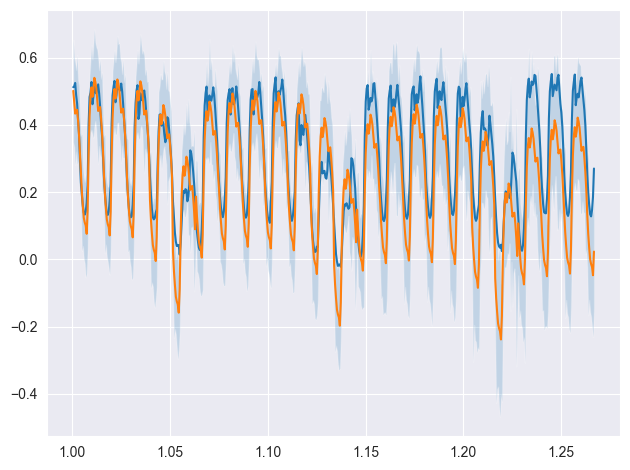

In [73]:
plt.plot(X_test[:, 0], y_test)
plt.plot(X_test[:, 0], preds_mean)
plt.fill_between(X_test[:, 0], preds_lower, preds_upper, alpha = 0.2)

## Model testing

Use get_fantasy_model method to update trained model's training data with new input sequences. Hyperparameters are not updated, which kind of mirrors the usage of input sequnces in NN models.

In [ ]:
# Evaluation pseudocode:
Create preds list
Perform feature scaling
Train until [:first_t]
Predict on first_t + horizon
Save preds
For pred points in [first_t:] // stride:
    Perform feature scaling
    Expand training set & online train
    Predict on first_t + eval index * stride + horizon
    Save preds
Concat & return preds, actual targets[first_t:]

In [ ]:
# Plot predicted vs. actual, entire test set

In [ ]:
# Plot predicted vs. actual, select sequences

In [ ]:
# Calculate performance metrics